<a href="https://colab.research.google.com/github/gcfer/reinforcement-learning/blob/main/RL_A2C_2N_CL2_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: A2C (Actor-Critic Method) — Two Networks — Custom Loss V2

## Overview

In this notebook, we'll cover the actor-critic framework and implement `A2C`, a state-of-the-art actor-critic algorithm. We'll test it by solving the cartpole problem in the Open AI gym. 

In [ ]:
import numpy as np
import pandas as pd
import datetime

# Import tensorflow
#!pip install tensorflow-gpu==1.14.0 > /dev/null 2>&1
import tensorflow as tf
import tensorflow.keras as K
print(tf.__version__)

# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

# Import libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

2.3.0



Since we are in a remote notebook, we cannot display the progress of the environment in real time. Instead, we store the renderings and show a video at the end of the episode (refer to [this](https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/) guide in case you need it). The only advice that I can give is to import `gym` _after_ the update below.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Maybe
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [ ]:
# Open AI gym
import gym 
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(2880, 1800))
display.start()

The function below is needed to display the video. I slightly modified it from the original one (that you can in the guide I linked above) to avoid the infinite repetition loop of the video.

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## OpenAI Gym Cartpole

The Cartpole problem is a discrete control problem where we try to keep the pole vertical by moving the cart below it. 

Upon loading the environment, we launch a simulation where the agent chooses at random from the action sample space the next action. Finally, we show the video of the result. What happens is that the problem is considered unsolved (= game over) if the angle between pole and the line orthogonal to the cart axis is larger than a threshold. The parameter `done` specifies when the experiment is over.

In [ ]:
# Load the environment and start
env = wrap_env(gym.make("CartPole-v0"))

In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
    if done: 
      break;
            
env.close()

In [ ]:
show_video()

To better understand the inputs and outputs of the environment, let consider the action space and the observation space.

The action space is of type `Discrete(n)` where `n` is the number of actions. This is equivalent to the discrete set $\{ 0, 1, 2, \dotsc, n-1 \}$.

In [ ]:
env.action_space

Discrete(2)

The observation space is of type `Box(n)`, which means that it is the Cartesian product of `n` intervals.

In [ ]:
env.observation_space

Box(4,)

In [ ]:
[env.observation_space.low, env.observation_space.high]

[array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32)]

When we make a step in the environment, the feedback that we get includes the observation:

In [ ]:
#env = gym.make('CartPole-v0')
# env = Monitor(env, './video', force=True)
env.reset()

obs, r, done, _ = env.step(0)
print(obs)

[ 0.0456236  -0.16100853 -0.01948453  0.2519396 ]


## Actor-Critic Algorithms

Actor-critic algorithms are policy gradient algorithms where the actor is driven by the value- or Q-function estimated by the critic. The role of the actor is to find the policy according to the policy gradient method. The role of the critic is to discover the value- or Q-function, and feed back the information about “how good” the action taken in the current state was. 

In policy gradient algorithms, the policy is updated on the basis of the discouted reward that is experienced. Let us recall that the policy $\pi_\theta$ is fit such that 
$$ \theta^* = \arg\max_\theta \mathbf{E}\!\left[R(\tau)\sum_{t=0}^T \log \pi_\theta(a_t|s_t)\right] $$
where
$$ R(\tau) =\sum_{t=0}^T\gamma^t r(s_t,a_t) $$
and $\tau=(s_0, a_0, r_0, \cdots, s_{T}, a_{T}, r_{T})$.

In practice, we fit the network so as to minimize the loss

$$  L(\tau) = - \sum_{t=0}^T R(\tau_{t}) \log (\pi_\theta(a_t)), $$

where $\tau_t=(s_t, a_t, r_t, \cdots, s_{T}, a_{T}, r_{T})$, at the end of each episode, and repeat the process over many episodes. We also know that, instead of using $R$, we can use a modified pre-log factor so as to reduce the variance in the learning process. This is accomplished through baselines, that is some function $b(s_t)$ that is removed from $R$:

$$  L(\tau) = - \sum_{t=0}^T [R(\tau_{t})-b(s_t)] \log (\pi_\theta(a_t)). $$

The fundamental problem with this approach is that the actor just tries actions and waits to see the reward at the end of the episode. This is equivalent to perfoming a task and by trial and error learning what to do better next time. 

It would be much better if, while performing the task, we could receive a feedback. The critic network is then introduced to do exactly that. How does the critic performs the critics though? It implements a DQN to find the Q-function or, in a simpler version, the value function. 

In other words, this is equivalent to having a teacher, but the teacher is learning while teaching. It is intuitive then that the critic needs to learn sooner than the actor how to perform its task, and so we'll set the learning rate of the critic larger than the one of the actor.

What the critic does is to infer the value function, which is $V(s_t)=\mathbf{E}[R(s_t)]$ with the best policy. Suppose the critic converges and learns it. Then we can set the value function as the baseline, $b(s):=V(s)$. The resulting pre-log factor,

$$  L(\tau) = - \sum_{t=0}^T A(\tau_{t}) \log (\pi_\theta(a_t)), $$

is called advantage. This is why `A2C` is called advantage actor critic.




In [ ]:
# A2C - Two networks
class A2C_2N_CL2:
  
  def __init__(self, state_size, action_size, gamma=None, max_steps=None):
    # max_steps is the maximum number of batches [s, a, r, s_] or epochs remembered
    
    # Parameters
    self.state_size = state_size
    self.action_size = action_size
    
    self.memory = list()
    if gamma is None: 
      self.gamma = 0.99
    else: 
      self.gamma = gamma
    
    if max_steps is None:
      self.max_steps = 200 
    else:
      self.max_steps = max_steps

    # learning rates
    self.actor_lr = 0.002  # best (empirically): 0.0008
    self.critic_lr = 3 * self.actor_lr

    # actor network
    self.actor = self.build_actor()

    # critic network
    self.critic = self.build_critic()

  def remember(self, s, a, r, s_, done):
    self.memory.append([s, a, r, s_, done])
    if len(self.memory) > self.max_steps: # if too long
      self.memory.pop(0) # forget the oldest
  
  def forget(self):
    self.memory = list()

  def custom_loss(self, y_true, y_pred):
    
    actions_one_hot = tf.cast(y_true, tf.float64)
    pol = tf.cast(y_pred, tf.float64)

    # loss = tf.keras.losses.categorical_crossentropy(actions_one_hot, pol)  # (batches, 1)

    probs = tf.reduce_sum(tf.math.multiply(actions_one_hot, pol), axis=1)
    probs = tf.clip_by_value(probs, 1e-9, 1.0)  # removes NaN
    
    log_probs = tf.math.log(probs)

    loss = -log_probs

    return loss

  def custom_loss_with_weights(self, y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    actions_one_hot, A = tf.split(y_true, [self.action_size, 1], 1)
    advantages = tf.keras.backend.flatten(A)
    pol = y_pred

    # loss = tf.keras.losses.categorical_crossentropy(actions_one_hot, pol)  # (batches, 1)

    probs = tf.reduce_sum(tf.math.multiply(actions_one_hot, pol), axis=1)
    probs = tf.clip_by_value(probs, 1e-9, 1.0)  # removes NaN
    
    log_probs = tf.math.log(probs)

    # compute loss
    loss = tf.reduce_sum(tf.math.multiply(advantages, -log_probs))
    # any nonlinearity does the trick: try to believe
    # loss = tf.reduce_sum(tf.math.multiply(advantages, -tf.math.sqrt(probs)))  
    return loss

  # actor learns the policy: input is state; output is distribution over actions (policy)
  def build_actor(self):
    n_hidden = 6 * self.state_size

    input_layer = K.layers.Input((self.state_size, ))
    output_layer = K.layers.Dense(n_hidden, activation='elu')(input_layer)
    output_layer = K.layers.Dense(n_hidden, activation='elu')(output_layer)
    output_layer = K.layers.Dense(self.action_size, activation='softmax')(output_layer)

    weight_layer = K.layers.Input((self.state_size, ))
    weight_layer.trainable = False

    model = K.models.Model([input_layer, weight_layer], output_layer)
    
    # loss is categorical_crossentropy since pi_theta (vector) should be equal to one-hot action (vector) eventually
    # because there is always a best action to be taken
    # model.compile(optimizer=K.optimizers.RMSprop(lr=self.actor_lr), loss='categorical_crossentropy') 
    model.compile(optimizer=K.optimizers.RMSprop(lr=self.actor_lr), loss=self.custom_loss_with_weights) 
    
    return model

  # critic network
  def build_critic(self, n_hidden_1=None, n_hidden_2=None):
        
    if n_hidden_1 == None:
      n_hidden_1 = 6 * self.state_size
      
    if n_hidden_2 == None:
      n_hidden_2 = 6 * self.state_size

    model = K.Sequential()
    model.add(K.layers.Dense(n_hidden_1, activation=tf.nn.elu, input_dim=self.state_size))  # first hidden layer
    model.add(K.layers.Dense(n_hidden_2, activation=tf.nn.elu))
    model.add(K.layers.Dense(1, activation=tf.nn.elu))  # output
    
    model.compile(optimizer=K.optimizers.Adam(lr=self.critic_lr), loss='mse') 
    
    return model

  # actor implements policy gradient
  def policy(self, s):
    policy = self.actor.predict(s, batch_size=1).flatten()
    a = np.random.choice(self.action_size, 1, p=policy)[0]
    return a

  # learn from memory
  def learn(self):

    # replay the entire episode
    s, a, r, s_, done = zip(*self.memory)
    a = np.reshape(a, (-1, 1))
    
    T = a.shape[0] # epochs in memory
    a_one_hot = np.zeros((T, self.action_size))
    a_one_hot[np.arange(T), a.reshape(-1)] = 1   # size: T x action_size
    
    target_actor = a_one_hot # actions
    
    cum_reward = np.cumsum((self.gamma ** np.arange(0, T)) * r)/(self.gamma ** np.arange(0, T))
    R = np.flip(cum_reward).reshape(-1, 1)
    s = np.concatenate(s) # or np.vstack(s)  
    v = self.critic.predict(s)
    A = R - v  # theoretical advantage (infinite-horizon problems)

    # s_ = np.concatenate(s_)
    # v_ = self.critic.predict(s_)
    # r = np.reshape(r, (-1, 1))
    # A = r + self.gamma * v_ - v  # advantage (same as above but works better in finite-horizon problems)
    
    # fit actor: sample_weight uses the weights to return a scalar_loss = weights.T * loss where loss is (batches, 1)  
    # self.actor.fit(s, target_actor, sample_weight=A, epochs=1, verbose=0)  # uses advantages

    # fit actor with batch weigh (no `sample_weight` provided)
    target_actor_A = np.concatenate([target_actor, A], axis=1)    
    self.actor.fit(s, target_actor_A, epochs=1, verbose=0)  # advantages are in the output

    # fit critic
    self.critic.fit(s, R, epochs=1, verbose=0)  # trained to get the value function 

## Training



In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Restart environment
# env = Monitor(env, './video', force=True)
MAX_REWARD = 200
env._max_episode_steps = MAX_REWARD

# Parameters
n_episodes = 350
winning_streak = 10  # after this number of successive successes, training stops
reward_history = np.zeros(n_episodes)
gamma = 0.99
steps_in_memory = MAX_REWARD  # number of steps to remember

A = np.arange(env.action_space.n)
dim_state_space = env.observation_space.shape[0]

# Start training
agent = A2C_2N_CL2(dim_state_space, env.action_space.n, gamma, steps_in_memory)

# init
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

template = "\rEpisode: {:3d}/{:3d} | Reward: {:3.0f} | Duration: {:.2f} s"

In [ ]:
for e in range(n_episodes):
  start_time = datetime.datetime.now()

  s = env.reset()
  s = np.reshape(s, [1, dim_state_space])
  
  done = False
  cum_reward = 0
  
  while not done:
    a = agent.policy(s)
    s_, r, done, _ = env.step(a)
    s_ = np.reshape(s_, [1, dim_state_space])
    agent.remember(s, a, r, s_, done)
    cum_reward += r
    s = s_
    
  agent.learn()
  agent.forget()
  
  dt = datetime.datetime.now() - start_time
  print(template.format(e+1, n_episodes, cum_reward, dt.total_seconds()), end='')
  
  reward_history[e] = cum_reward
  
  if e > winning_streak and np.sum(reward_history[e-winning_streak:e]) >= winning_streak * MAX_REWARD:
    break

Episode: 141/350 | Reward: 200 | Duration: 6.50 s

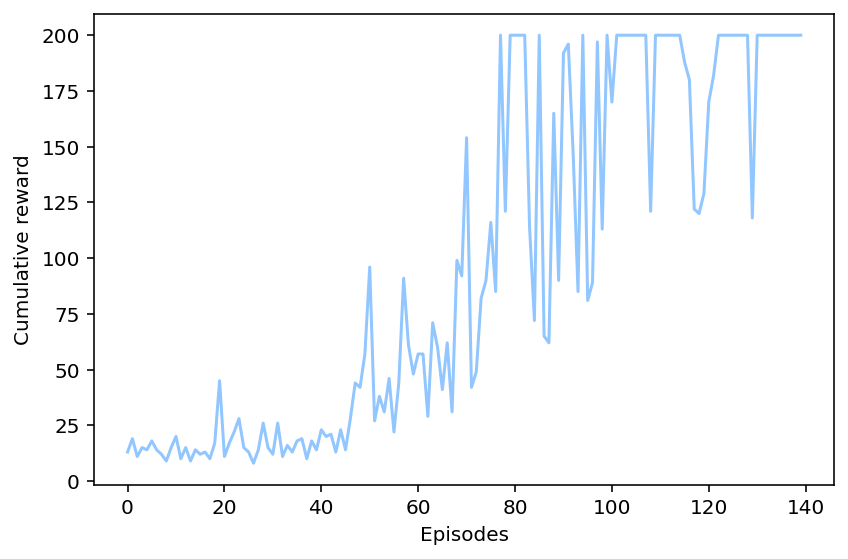

In [ ]:
plt.plot(reward_history[0:e], label='Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.tight_layout()
plt.show()

## Trying it

In [ ]:
env = wrap_env(gym.make("CartPole-v0"))
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

done = False
cum_reward = 0

while not done:

  env.render()
  a = agent.policy(s)
  s_, r, done, _ = env.step(a)
  s_ = np.reshape(s_, [1, dim_state_space])
  agent.remember(s, a, r, s_, done)
  cum_reward += r
  s = s_

env.close()

print('We got a reward equal to {:.0f}'.format(cum_reward))

We got a reward equal to 200


In [ ]:
show_video()